# 2D GAN of s1 vs s2  - 26/10/19

s1 vs s2 is an important relationship for the GAN to understand and to be able to recreate. This notebook creates a GAN which accurately recreates a 2D histogram. It is completed in Google Colab for the extra computing power it offered.

<font color='orange'>16/11/19 - It has been brought to our attention that the S1 and S2 variables have not been accurately reproduced in this dataset. </font>

In [0]:
pip install uproot

     |████████████████████████████████| 122kB 4.9MB/s 
     |████████████████████████████████| 92kB 8.1MB/s 


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My\ Drive/test_run

/content/gdrive/My Drive/test_run


Import relevant libraries & use uproot to open it.

In [0]:
import uproot
import pandas
import matplotlib.pyplot as plt
import numpy as np

tree = uproot.open("outRunNeutron2.root")["dstree"]

## Understand the data

The different variables contained within the tree. This is usually done at the start of every Jupyter notebook to allow me to make sure I have the variables and the types of the variables available. Generally this is good habit and is something I would recommend. 

If you have problems with a variable, I would strongly recommend opening the file in a TBrowser in root.

Some variables are given as lists of lists, and therefore need to be 'unpacked'.

The different variables contained within the tree.

In [0]:
tree.show()

ev                         (no streamer)              asdtype('>i4')
pdg                        (no streamer)              asdtype('>i4')
ene0                       (no streamer)              asdtype('>f4')
s1ene                      (no streamer)              asdtype('>f4')
s2ene                      (no streamer)              asdtype('>f4')
veto_visene                (no streamer)              asdtype('>f4')
mu_visene                  (no streamer)              asdtype('>f4')
tpcene                     (no streamer)              asdtype('>f4')
vetoene                    (no streamer)              asdtype('>f4')
muene                      (no streamer)              asdtype('>f4')
ene                        (no streamer)              asdtype('>f4')
x                          (no streamer)              asdtype('>f4')
y                          (no streamer)              asdtype('>f4')
z                          (no streamer)              asdtype('>f4')
r                          (no str

## Getting the s1 and s2 variables

From the list of variables stored in the root file, we can extract the relevant variables we would like to use to create a 2D histogram. Some of these variables may require further manipulation, and this is also done here.

norm1 and norm2 must be calualted by plotting the graph then finding the normalisation to make them both the same order of magnitude. 

(100,)


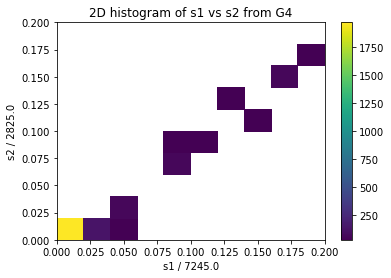

In [0]:
s1 = np.array(tree.array("s1ene"))
s2 = np.array(tree.array("s2ene"))
a1 = s1 / s1.max()
a2 = s2 / s2.max()
print(a1.shape)
train = np.matrix([a1,a2])
train = train.T
train = np.array(train)
plt.hist2d(a1, a2, bins=10, range=[[0, 0.2], [0, 0.2]],cmin = 1, density=True)
plt.xlabel(f"s1 / {round(s1.max())}")
plt.ylabel(f"s2 / {round(s2.max())}")
plt.title("2D histogram of s1 vs s2 from G4")
plt.colorbar()
plt.show()

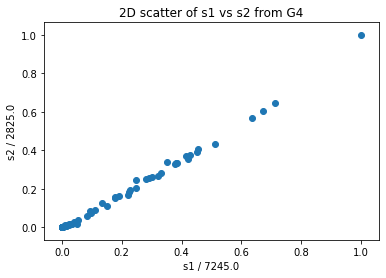

In [0]:
plt.scatter(a1, a2)
plt.xlabel(f"s1 / {round(s1.max())}")
plt.ylabel(f"s2 / {round(s2.max())}")
plt.title("2D scatter of s1 vs s2 from G4")  
plt.show()

We then set the number of training examples and the size of the noise. In this case, I set the noise size to 1000, thinking it had to be the same as the training data. However this is not the case, as the generator will transform the noise data into the appropriate number of points. 

Something that may be interesting to explore later is the effect of **varying the size of the noise** 

In [0]:
num_train = int(1e4)
noise_size = 1000
epochs     = 10000
batch_size = 1000

## Creation of the GAN

After setting some variables, the GAN is created. Generally there is no 'official documentation' on the correct setup of either the generator or disciminator. However the output of the disciminator should be a softmax, so it outputs a probability of the point being real/fake.

Binary Crossentropy is used to compare a probability (probaility image is real) with a 0,1 which is if it is real or fake. 

The generator is trying to maximise this, and make the disciminator bad at telling the difference, whilst the disciminator is trying to minimise this. 

A simple overview is found on this website: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

In [0]:
#  Create GAN

from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU
from keras.models     import Model, Sequential
from keras.optimizers import Adam



#Discriminator
#See how number of neurons are sae for each layer to reduce number of hyperparameters
d = Sequential(name="Discriminator")
d.add(Dense(20, activation="relu", input_shape=(2,)))
#d.add(Dropout(0.2))
#Input shape would be number of parameters
#d.add(Dense(20, activation="relu"))
#d.add(Dropout(0.4))
#d.add(Dropout(0.2))
d.add(LeakyReLU(0.1))
d.add(Dense(2, activation="softmax"))
d.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
d.summary()

g = Sequential(name="Generator")
g.add(Dense(100, activation="relu", input_shape=(noise_size,)))
#d.add(Dropout(0.2))
g.add(BatchNormalization())
g.add(Dense(100, activation="relu"))
g.add(BatchNormalization())
g.add(LeakyReLU(0.2))
#THe number of outputs here should be the number of dimensions
g.add(Dense(2, activation="linear"))
g.summary()

input_layer = Input((noise_size,))
output_layer = d(g(input_layer))
gan = Model(input_layer, output_layer)
d.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
gan.summary()

Using TensorFlow backend.







Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                60        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               100100    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
______________________________

In [0]:
def noisegenerator(batch_size, noise_size):
    return np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Discriminator loss: 0.5733627
Discriminator acc: 0.5155


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


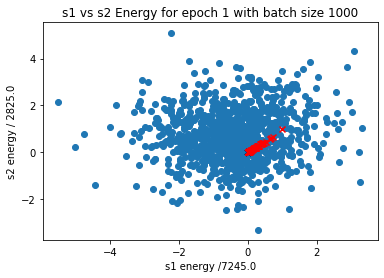

Discriminator loss: 0.61871713
Discriminator acc: 0.8625


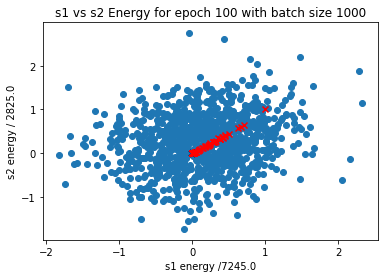

Discriminator loss: 0.630116
Discriminator acc: 0.862


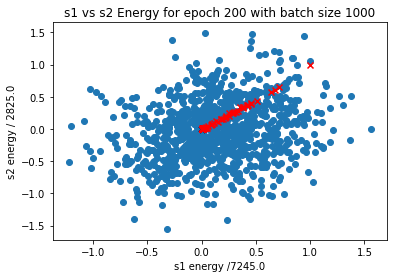

Discriminator loss: 0.63600963
Discriminator acc: 0.8515


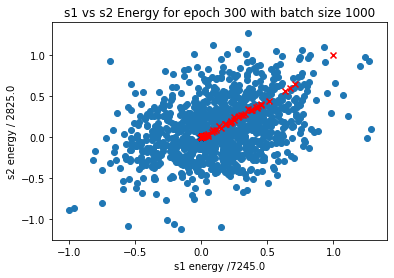

Discriminator loss: 0.64660317
Discriminator acc: 0.807


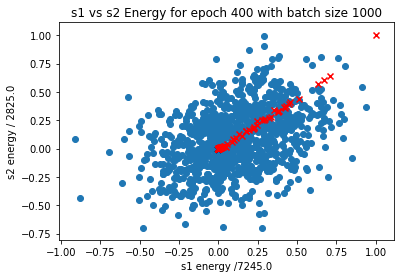

Discriminator loss: 0.65628445
Discriminator acc: 0.7875


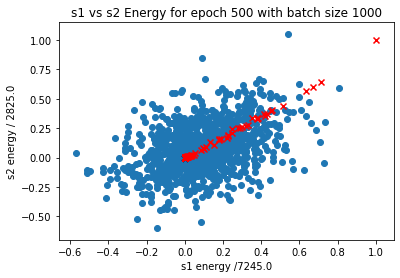

Discriminator loss: 0.6668003
Discriminator acc: 0.703


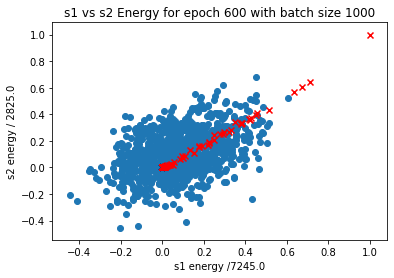

Discriminator loss: 0.671618
Discriminator acc: 0.665


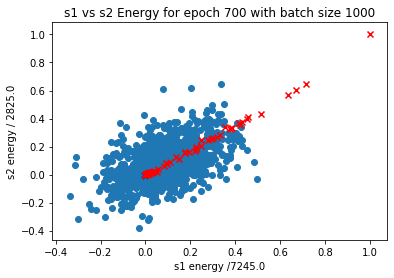

Discriminator loss: 0.6747435
Discriminator acc: 0.654


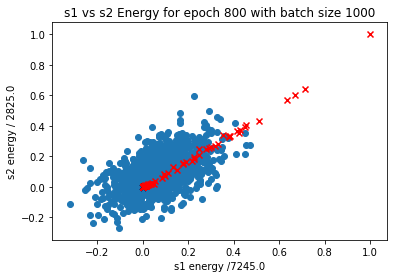

Discriminator loss: 0.6788245
Discriminator acc: 0.626


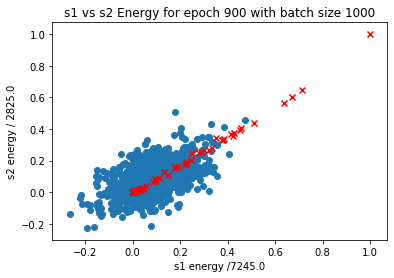

Discriminator loss: 0.67961365
Discriminator acc: 0.6295


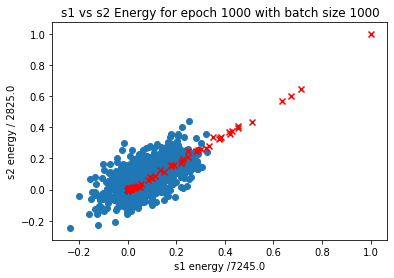

Discriminator loss: 0.6820408
Discriminator acc: 0.6175


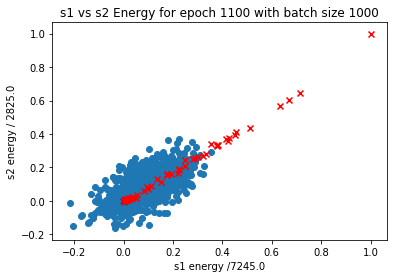

Discriminator loss: 0.6849037
Discriminator acc: 0.613


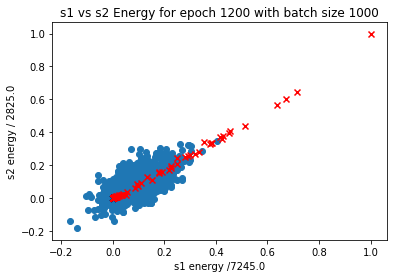

Discriminator loss: 0.68544215
Discriminator acc: 0.6265


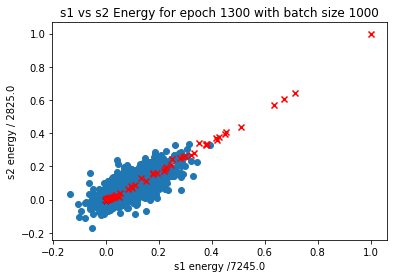

Discriminator loss: 0.68635535
Discriminator acc: 0.6305


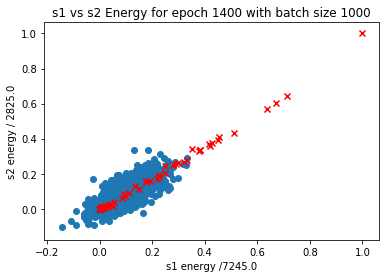

Discriminator loss: 0.6874633
Discriminator acc: 0.632


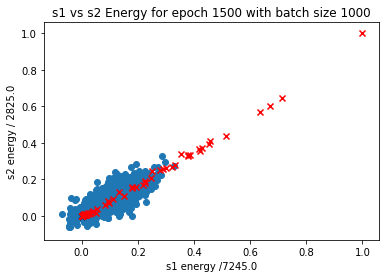

Discriminator loss: 0.68784875
Discriminator acc: 0.664


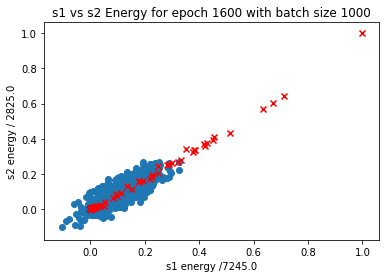

Discriminator loss: 0.6882881
Discriminator acc: 0.681


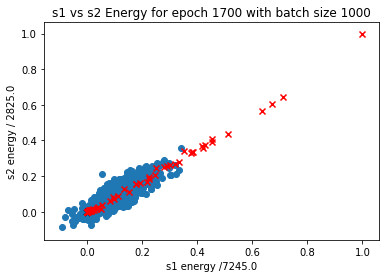

Discriminator loss: 0.6885787
Discriminator acc: 0.6625


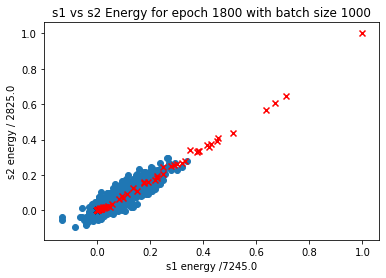

Discriminator loss: 0.68941045
Discriminator acc: 0.6675


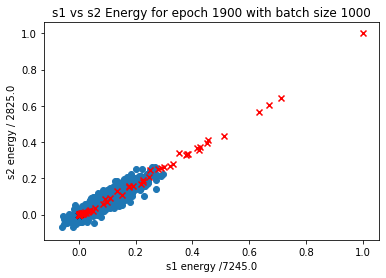

Discriminator loss: 0.68987465
Discriminator acc: 0.6615


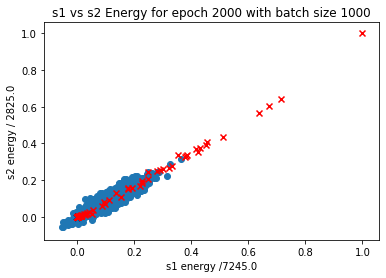

Discriminator loss: 0.6905367
Discriminator acc: 0.6695


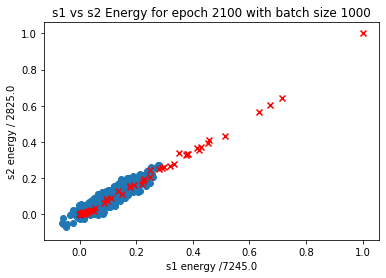

Discriminator loss: 0.6910453
Discriminator acc: 0.645


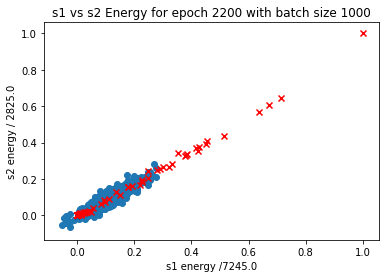

Discriminator loss: 0.6910482
Discriminator acc: 0.6635


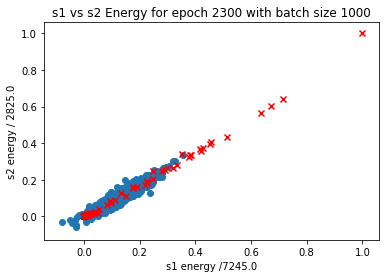

Discriminator loss: 0.69135064
Discriminator acc: 0.6575


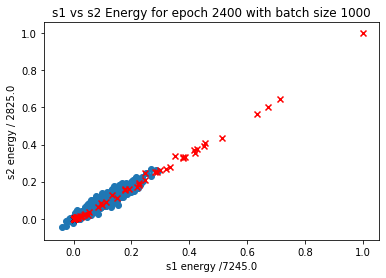

Discriminator loss: 0.6915082
Discriminator acc: 0.6545


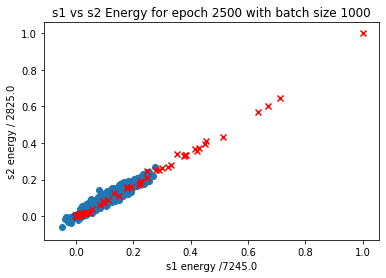

Discriminator loss: 0.6918395
Discriminator acc: 0.6275


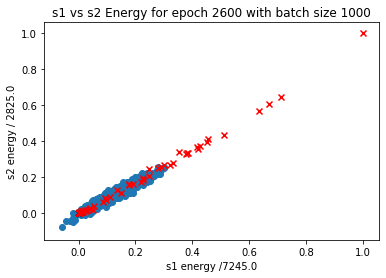

Discriminator loss: 0.6920231
Discriminator acc: 0.6155


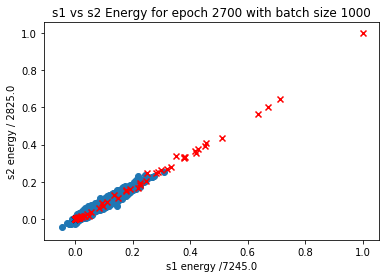

Discriminator loss: 0.6920302
Discriminator acc: 0.638


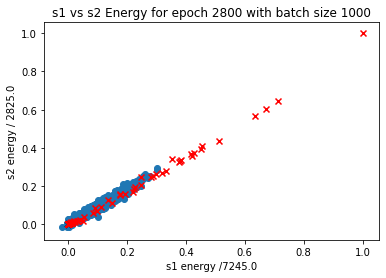

Discriminator loss: 0.6927154
Discriminator acc: 0.5775


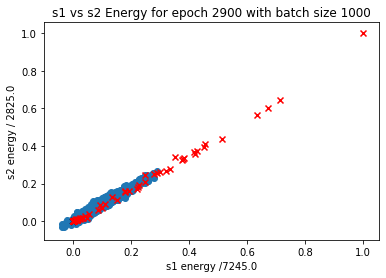

Discriminator loss: 0.6924226
Discriminator acc: 0.6175


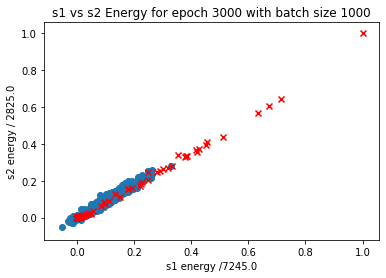

Discriminator loss: 0.69217074
Discriminator acc: 0.6255


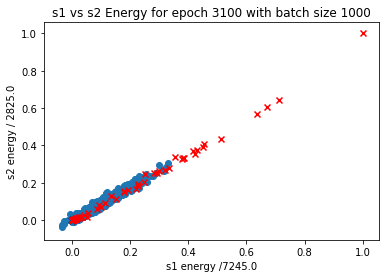

Discriminator loss: 0.6923878
Discriminator acc: 0.615


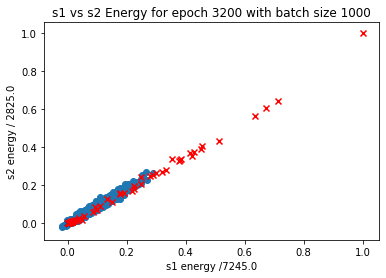

Discriminator loss: 0.6927014
Discriminator acc: 0.587


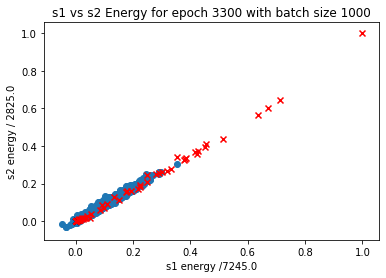

Discriminator loss: 0.6931461
Discriminator acc: 0.572


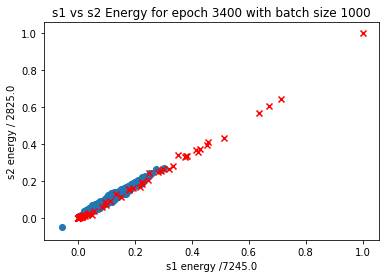

Discriminator loss: 0.6931759
Discriminator acc: 0.5615


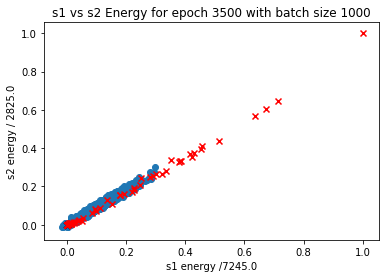

Discriminator loss: 0.6929795
Discriminator acc: 0.559


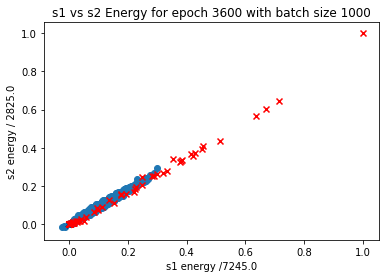

Discriminator loss: 0.6930519
Discriminator acc: 0.564


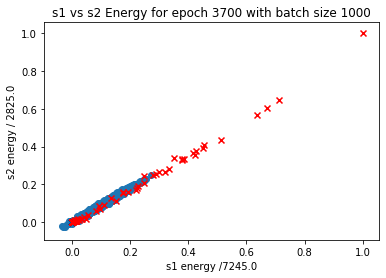

Discriminator loss: 0.69333786
Discriminator acc: 0.5615


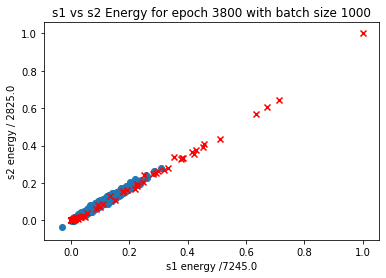

Discriminator loss: 0.69317335
Discriminator acc: 0.5705


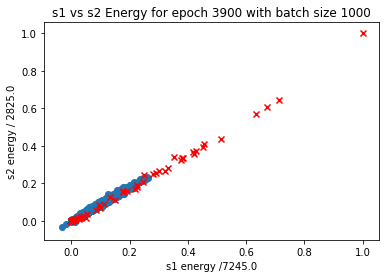

Discriminator loss: 0.69327563
Discriminator acc: 0.5305


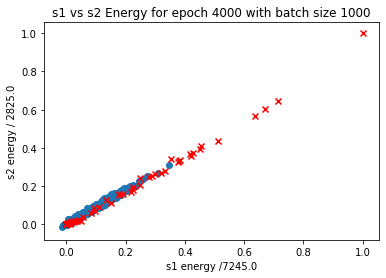

Discriminator loss: 0.6935678
Discriminator acc: 0.482


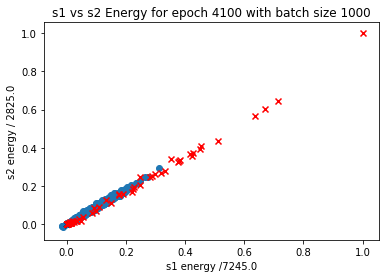

Discriminator loss: 0.69323623
Discriminator acc: 0.626


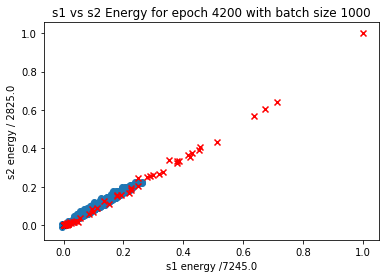

Discriminator loss: 0.6930781
Discriminator acc: 0.532


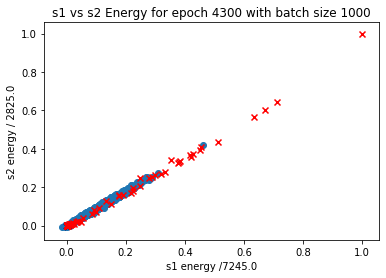

Discriminator loss: 0.69415015
Discriminator acc: 0.6255


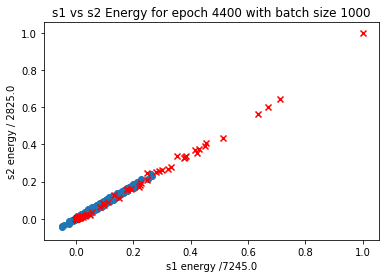

Discriminator loss: 0.6911881
Discriminator acc: 0.3095


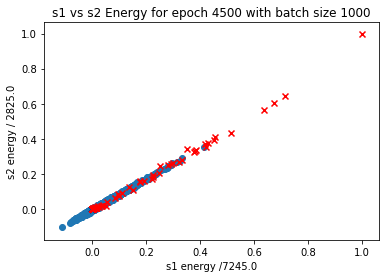

Discriminator loss: 0.6929845
Discriminator acc: 0.5


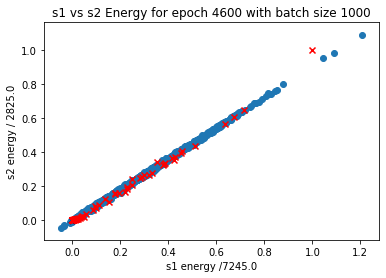

Discriminator loss: 0.56330764
Discriminator acc: 0.879


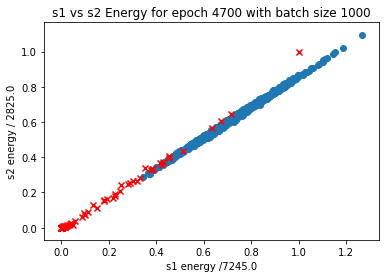

Discriminator loss: 0.71289915
Discriminator acc: 0.391


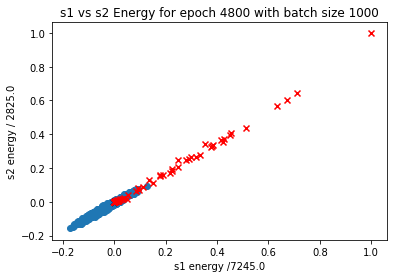

Discriminator loss: 0.7024834
Discriminator acc: 0.377


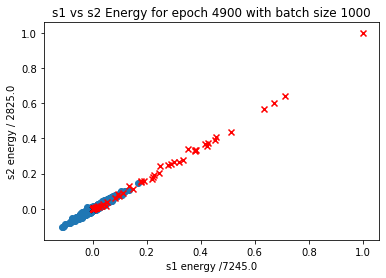

Discriminator loss: 0.69830924
Discriminator acc: 0.5


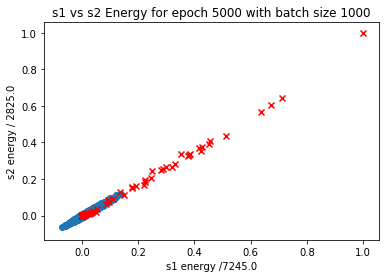

Discriminator loss: 0.70564455
Discriminator acc: 0.197


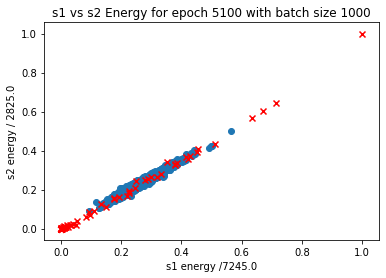

Discriminator loss: 0.71071595
Discriminator acc: 0.3595


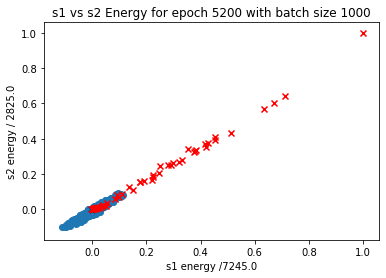

Discriminator loss: 0.6992263
Discriminator acc: 0.39


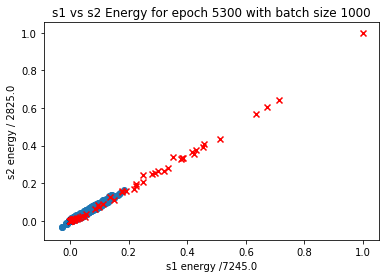

Discriminator loss: 0.69386584
Discriminator acc: 0.3465


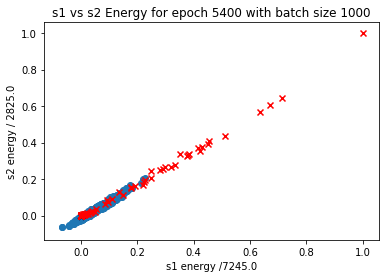

Discriminator loss: 0.68014497
Discriminator acc: 0.5


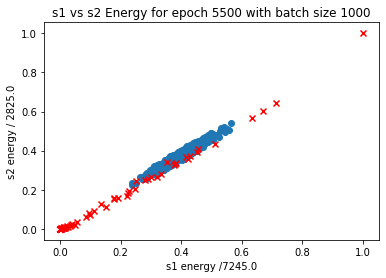

Discriminator loss: 0.6998649
Discriminator acc: 0.4815


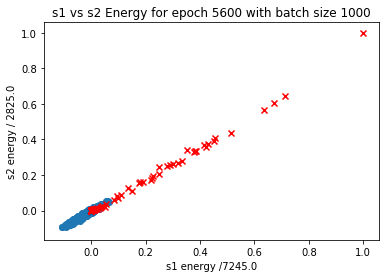

Discriminator loss: 0.6984939
Discriminator acc: 0.4


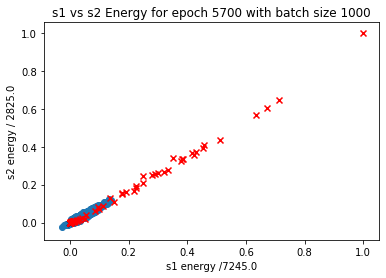

Discriminator loss: 0.6936372
Discriminator acc: 0.2265


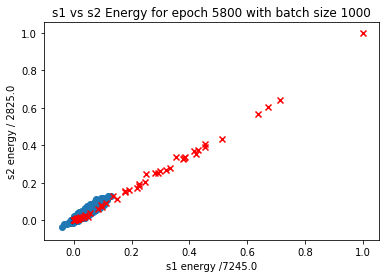

Discriminator loss: 0.69064087
Discriminator acc: 0.32


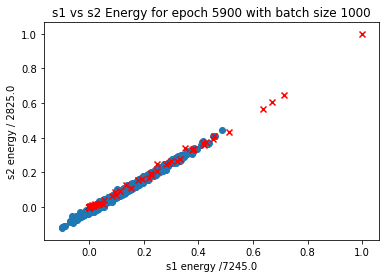

Discriminator loss: 0.5943031
Discriminator acc: 0.888


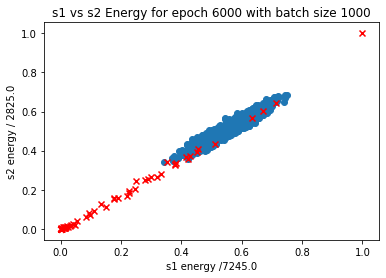

Discriminator loss: 0.7115713
Discriminator acc: 0.3725


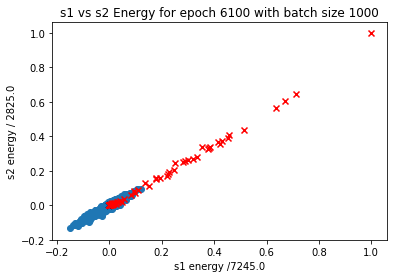

Discriminator loss: 0.7042114
Discriminator acc: 0.4385


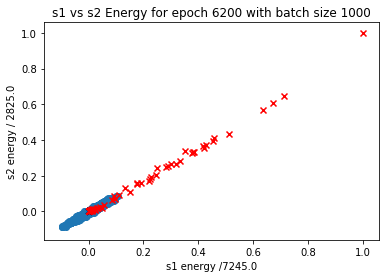

Discriminator loss: 0.698911
Discriminator acc: 0.386


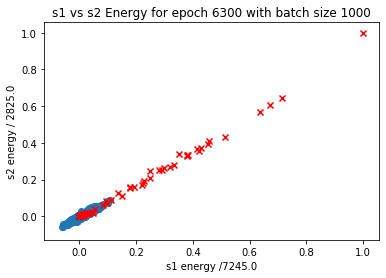

Discriminator loss: 0.6938451
Discriminator acc: 0.488


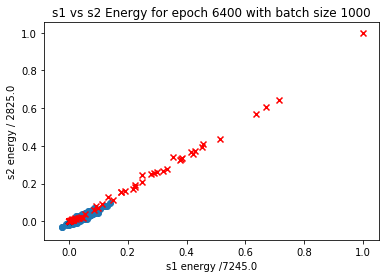

Discriminator loss: 0.6929071
Discriminator acc: 0.296


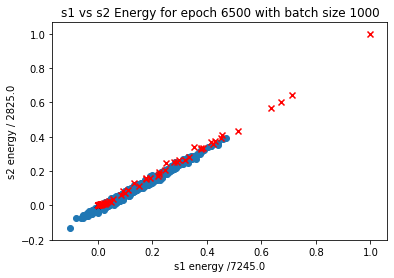

Discriminator loss: 0.6336745
Discriminator acc: 0.864


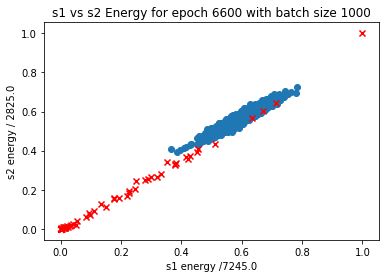

Discriminator loss: 0.7102916
Discriminator acc: 0.3445


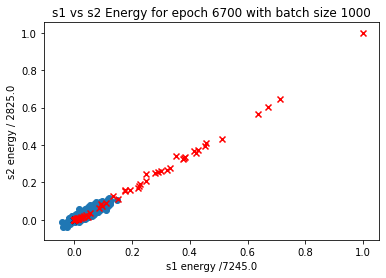

Discriminator loss: 0.7051161
Discriminator acc: 0.3605


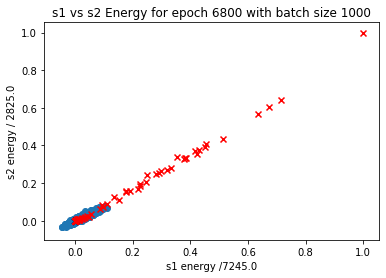

Discriminator loss: 0.70100576
Discriminator acc: 0.3375


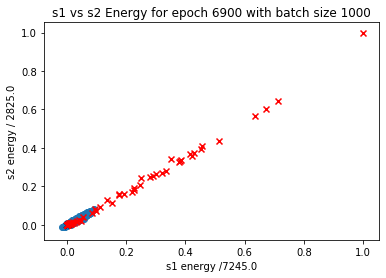

Discriminator loss: 0.69549865
Discriminator acc: 0.3515


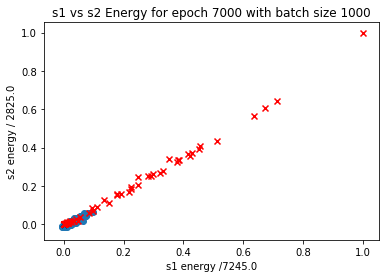

Discriminator loss: 0.6927083
Discriminator acc: 0.45


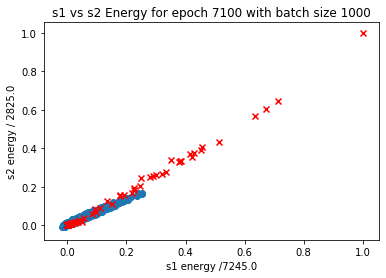

Discriminator loss: 0.69457394
Discriminator acc: 0.528


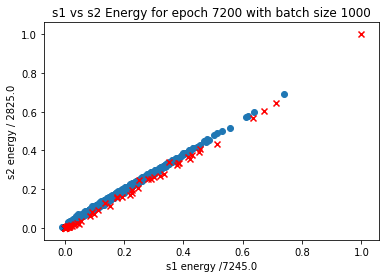

Discriminator loss: 0.6760669
Discriminator acc: 0.848


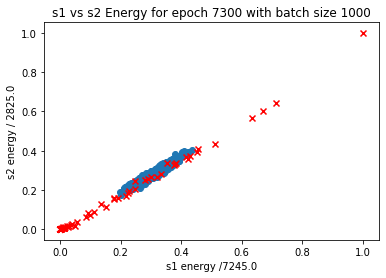

Discriminator loss: 0.6966205
Discriminator acc: 0.368


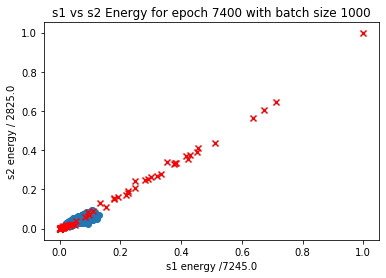

Discriminator loss: 0.696249
Discriminator acc: 0.3495


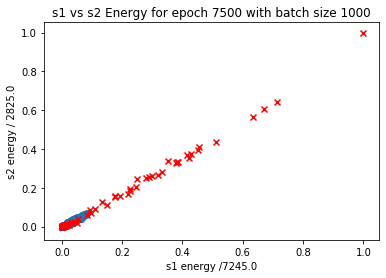

Discriminator loss: 0.69171774
Discriminator acc: 0.58


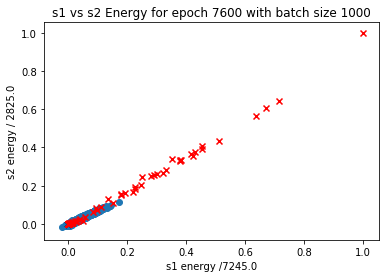

Discriminator loss: 0.69612837
Discriminator acc: 0.3465


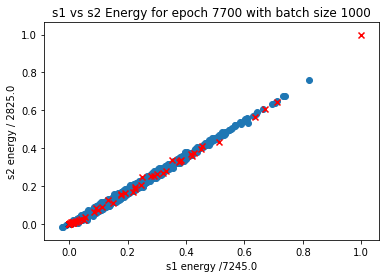

Discriminator loss: 0.6690732
Discriminator acc: 0.8115


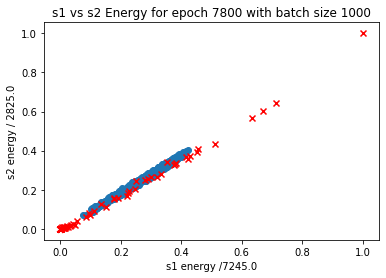

Discriminator loss: 0.69769615
Discriminator acc: 0.489


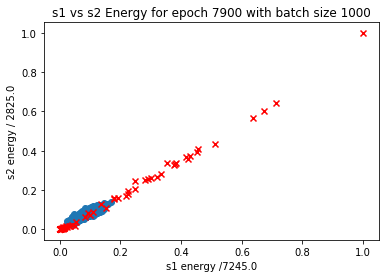

Discriminator loss: 0.6996769
Discriminator acc: 0.362


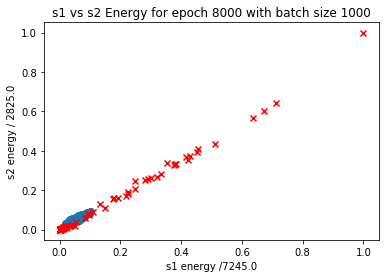

Discriminator loss: 0.6978586
Discriminator acc: 0.345


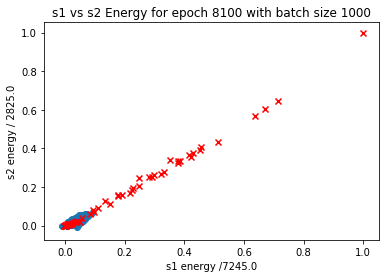

Discriminator loss: 0.6928084
Discriminator acc: 0.4955


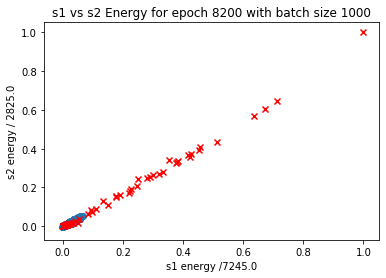

Discriminator loss: 0.69204843
Discriminator acc: 0.365


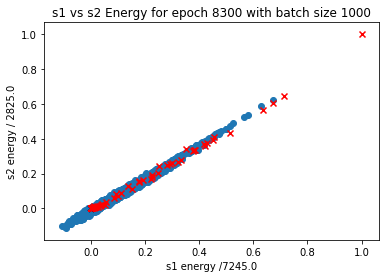

Discriminator loss: 0.6596512
Discriminator acc: 0.875


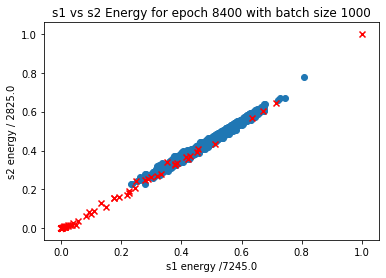

Discriminator loss: 0.69339186
Discriminator acc: 0.6535


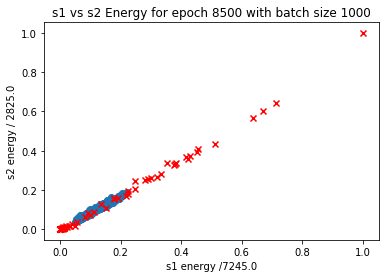

Discriminator loss: 0.7017499
Discriminator acc: 0.438


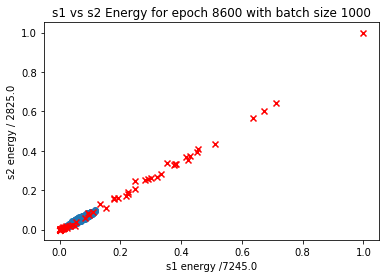

Discriminator loss: 0.7023716
Discriminator acc: 0.336


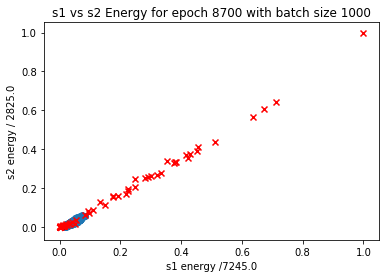

Discriminator loss: 0.69730574
Discriminator acc: 0.339


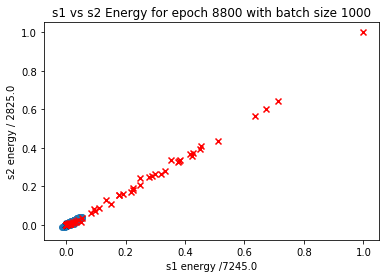

Discriminator loss: 0.6898676
Discriminator acc: 0.542


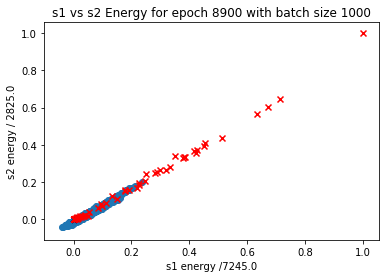

Discriminator loss: 0.6934385
Discriminator acc: 0.5


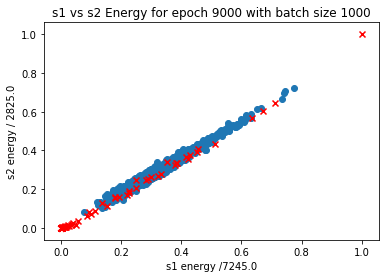

Discriminator loss: 0.67702836
Discriminator acc: 0.739


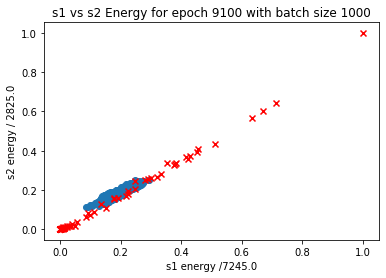

Discriminator loss: 0.70739406
Discriminator acc: 0.3505


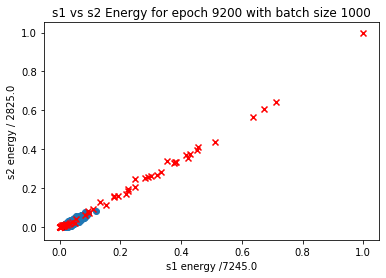

Discriminator loss: 0.70518225
Discriminator acc: 0.3365


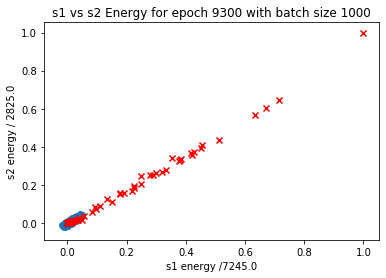

Discriminator loss: 0.6956781
Discriminator acc: 0.3845


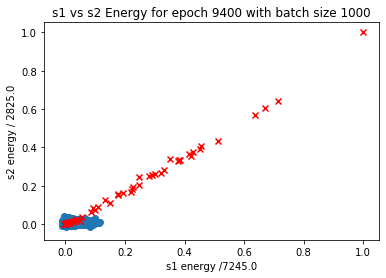

Discriminator loss: 0.6916611
Discriminator acc: 0.856


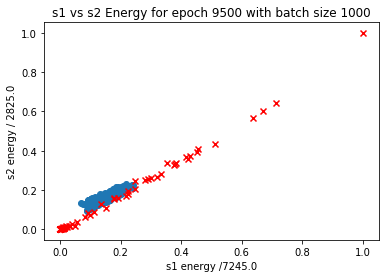

Discriminator loss: 0.68775403
Discriminator acc: 0.8065


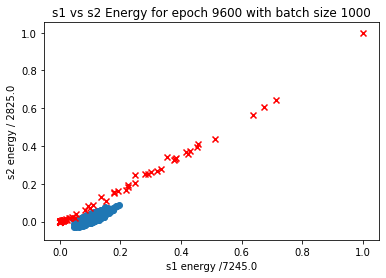

Discriminator loss: 0.69277483
Discriminator acc: 0.6325


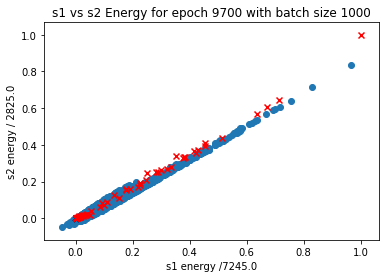

Discriminator loss: 0.687369
Discriminator acc: 0.7065


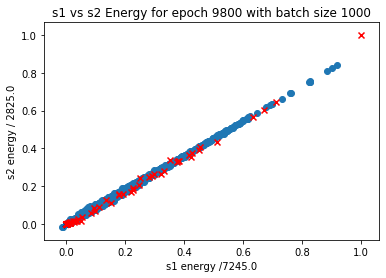

Discriminator loss: 0.69496924
Discriminator acc: 0.407


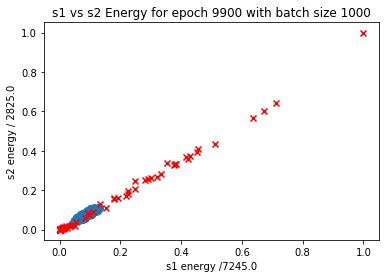

Discriminator loss: 0.6933348
Discriminator acc: 0.5125


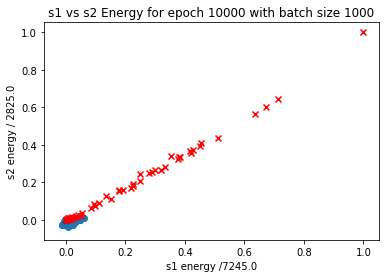

In [0]:
import tensorflow as tf
epochs_saved = []
acc = []
real_loss = []
real_acc = []
epoch_no = []
for e in range(epochs) :
    noise  = noisegenerator(batch_size, noise_size)

    batch_DS = train[np.random.choice(train.shape[0], batch_size, replace=True), :]
    #fake data made from predicting noise
    gen_DS   = g.predict(noise).reshape(batch_size, 2)
    
    #Real data has label [1.,0]
    real_label = np.array([[1., 0.] for i in range(batch_size)])
    
    #Fake data has label [0.,1.]
    fake_label = np.array([[0., 1.] for i in range(batch_size)])
    
    #Combine real and generated data
    X = np.concatenate([batch_DS  , gen_DS    ])
    Y = np.concatenate([real_label, fake_label])
    
    d.trainable = True
    d_loss, d_acc = d.train_on_batch(X, Y)

        
    noise  = noisegenerator(batch_size, noise_size)
    d.trainable = False
    gan.train_on_batch(noise, real_label)
    
    if e == 0 or (e+1) % 100 == 0 :
        noise  = noisegenerator(batch_size, noise_size)
        gen_DS = g.predict(noise)
        dis_loss, dis_acc = d.train_on_batch(X, Y)
        print("Discriminator loss: " + str(dis_loss))
        print("Discriminator acc: " + str(dis_acc))
        #print("Generator: " + gan.train_on_batch(noise, real_label))
        epoch_no.append(e)
        acc.append(d_acc)
        #x, y = np.hsplit(gen_DS, 2)
        x = np.asarray(gen_DS)[:,0]
        y = np.asarray(gen_DS)[:,1]
        plt.scatter(x, y)
        plt.scatter(a1, a2, c = 'red', marker= 'x')
        plt.xlabel(f"s1 energy /{round(s1.max())}")
        plt.ylabel(f"s2 energy / {round(s2.max())}")
        plt.title(f"s1 vs s2 Energy for epoch {e+1} with batch size {batch_size}")
        plt.show()
        real_loss.append(d_loss)
        real_acc.append(d_acc)
        epochs_saved.append(e+1)

## Plotting Discriminator Accuracy

As the generator gets better at fooling the disciminator, the accuracy of the disciminator should decrease, as it finds it harder to tell the difference.

In [0]:
len(real_loss)

101

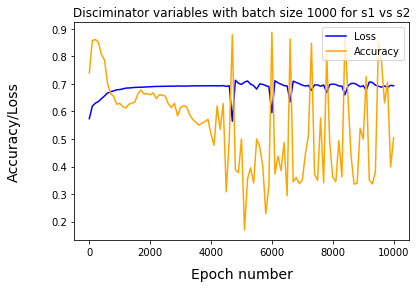

In [0]:
h3 = plt.plot(epoch_no,real_loss, color = 'blue', label = "Loss")
h4 = plt.plot(epoch_no,real_acc, color = 'orange', label = "Accuracy")
plt.xlabel("Epoch number", size=14, labelpad=10)
plt.ylabel("Accuracy/Loss", size=14, labelpad=30, rotation="vertical")
plt.title(f"Disciminator variables with batch size {batch_size} for s1 vs s2")
plt.legend(loc="upper right", fontsize=10)
plt.show()

## Checking 1D distributions

By learning 2D distributions, the 1D distributuon of s1 and s2 sepearately should also have been learnt. This is checked below, and uses a custom loss function which siply sums the differences in the sizes of the bins of the real and generated graphs.

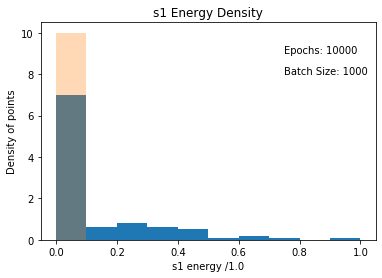

In [0]:
s1_true = plt.hist(a1, density = True,range = (0,1), bins = 10)
s1_gen = plt.hist(x, density = True,range = (0,1), bins = 10, alpha = 0.3)
s1_diff = s1_true[0] - s1_gen[0]

sum_s1_diff = 0
for i in range(len(s1_diff)):
  sum_s1_diff += abs(s1_diff[i])

#plt.text(0.75,10,f"Loss: {round(sum_s1_diff)}")
plt.text(0.75,9,f"Epochs: {epochs}")
plt.text(0.75,8,f"Batch Size: {batch_size}")
plt.xlabel(f"s1 energy /{round(a1.max())}")
plt.ylabel("Density of points")
plt.title("s1 Energy Density")
plt.show()


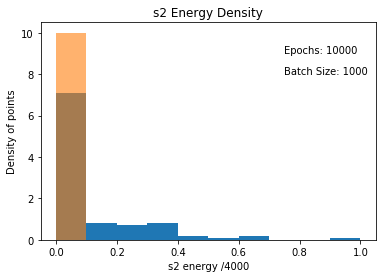

In [0]:
train_DS2 = a2
s2_true = plt.hist(a2, density = True,range = (0,1), bins = 10)
s2_gen = plt.hist(y, density = True,alpha = 0.6,range = (0,1), bins = 10)
plt.xlabel(f"s2 energy /{round(a2.max())}")
plt.ylabel("Density of points")
plt.title("Distribution of s2 Energy")
s2_diff = s2_true[0] - s2_gen[0]

sum_s2_diff = 0
for i in range(len(s1_diff)):
  sum_s2_diff += abs(s2_diff[i])


#plt.text(0.75,10,f"Loss: {round(sum_s2_diff)}")
plt.text(0.75,9,f"Epochs: {epochs}")
plt.text(0.75,8,f"Batch Size: {batch_size}")
plt.xlabel("s2 energy /4000")
plt.ylabel("Density of points")
plt.title("s2 Energy Density")
plt.show()

In [0]:
s1_diff = s1_true[0] - s1_gen[0]
s2_diff = s2_true[0] - s2_gen[0]
sum_s1_diff = 0
sum_s2_diff = 0
for i in range(len(s1_diff)):
  sum_s1_diff += abs(s1_diff[i])
  sum_s2_diff += abs(s2_diff[i])

print("s1 difference is: " + str(sum_s1_diff))
print("s2_difference is: " + str(sum_s2_diff))

s1 difference is: 5.9999999403954085
s2_difference is: 5.799999965727375
